In [1]:
# TODO: decode predict values
import numpy as np
import tensorflow as tf

In [2]:
num_classes = 21
_top_k = 400
_nms_threshold = 0.45

boxes = tf.placeholder(dtype='float32', shape=(None, 4))
scores = tf.placeholder(dtype='float32', shape=(None,))

sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
nms = tf.image.non_max_suppression(boxes, scores, _top_k, iou_threshold=_nms_threshold)

In [3]:
def decode_boxes(mbox_loc, mbox_priorbox, variances):
    """ Convert bboxes from local predictions to shifted priors. 
    Q: Whats shifted priors?
    A: In predictive results, we got offsets and must to 'shift' prior_center with.
    
    Q: Why use exponential as converted coefficients to width and height?
    A: I do not figure it out.
    """
    prior_width = mbox_priorbox[:, 2] - mbox_priorbox[:, 0]
    prior_height = mbox_priorbox[:, 3] - mbox_priorbox[:, 1]
    
    prior_center_x = 0.5 * (mbox_priorbox[:, 2] + mbox_priorbox[:, 0])
    prior_center_y = 0.5 * (mbox_priorbox[:, 3] + mbox_priorbox[:, 1])
    # decode x
    decode_bbox_center_x = mbox_loc[:, 0] * prior_width * variances[:, 0]
    decode_bbox_center_x += prior_center_x
    # decode y
    decode_bbox_center_y = mbox_loc[:, 1] * prior_height * variances[:, 1]
    decode_bbox_center_y += prior_center_y
    # decode width
    decode_bbox_width = np.exp(mbox_loc[:, 2] * variances[:, 2])
    decode_bbox_width *= prior_width
    # decode height
    decode_bbox_height = np.exp(mbox_loc[:, 3] * variances[:, 3])
    decode_bbox_height *= prior_height
    # decode [xmin, ymin, xmax, ymax]
    decode_bbox_xmin = decode_bbox_center_x - 0.5 * decode_bbox_width
    decode_bbox_ymin = decode_bbox_center_y - 0.5 * decode_bbox_height
    decode_bbox_xmax = decode_bbox_center_x + 0.5 * decode_bbox_width
    decode_bbox_ymax = decode_bbox_center_y + 0.5 * decode_bbox_height
    
    decode_bbox = np.concatenate((decode_bbox_xmin[:, None], decode_bbox_ymin[:, None], 
                                 decode_bbox_xmax[:, None], decode_bbox_ymax[:, None]), axis=-1)
    
    decode_bbox = np.minimum(np.maximum(decode_bbox, 0.0), 1.0)
    return decode_bbox    

In [4]:
def detection_out(predictions, background_label_id=0, keep_top_k=200, confidence_threshold=0.01):
    """ do nms """
    # core
    mbox_loc = predictions[:, :, :4]
    variances = predictions[:, :, -4:]
    mbox_priorbox = predictions[:, :, -8:-4]
    mbox_conf = predictions[:, :, 4:-8]
    
    results = []
    
    # 1. decode bbox -> 2. get valid class and its boxes coordinations
    for i in range(len(mbox_loc)):
        results.append([])
        # core
        decode_bbox = decode_boxes(mbox_loc[i], mbox_priorbox[i], variances[i])
        for c in range(num_classes):
            if c == background_label_id:
                continue
            c_confs = mbox_conf[i, :, c]
            c_confs_m = c_confs > confidence_threshold
            if len(c_confs_m) > 0:
                # core
                boxes_to_process = decode_bbox[c_confs_m]
                confs_to_process = c_confs[c_confs_m]
                feed_dict = {boxes: boxes_to_process, scores: confs_to_process}
                idx = sess.run(nms, feed_dict=feed_dict)
                
                good_boxes = boxes_to_process[idx]
                confs = confs_to_process[idx][:, None]
                labels = c * np.ones((len(idx), 1))
                c_pred = np.concatenate((labels, confs, good_boxes), axis=1)
                results[-1].extend(c_pred)
        if len(results[-1]) > 0:
            results[-1] = np.array(results[-1])
            # sort label idx with decending
            argsort = np.argsort(results[-1][:, 1])[::-1]
            results[-1] = results[-1][argsort]
            results[-1] = results[-1][:keep_top_k]
    return results

Using TensorFlow backend.


14
15


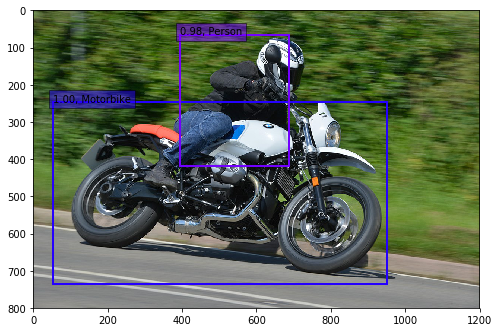

In [5]:
# test it
from keras.backend.tensorflow_backend import set_session
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from scipy.misc import imread

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']

input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=num_classes)
model.load_weights('weights_SSD300.hdf5', by_name=True)

inputs = []
images = []

# img_path = './pics/fish-bike.jpg'
# img_path = './pics/my-test-motor.jpg'
img_path = './pics/my-test-motor-man.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
# for imshow usage
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

results = model.predict(inputs, batch_size=1)
results = detection_out(results)

for i, img in enumerate(images):
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]
    
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
    
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    
    plt.imshow(img / 255.)
    currentAxis = plt.gca()
    
    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        
        score = top_conf[i]
        label = int(top_label_indices[i])
        print label
        label_name = voc_classes[label-1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor': color, 'alpha': 0.5})
    
    plt.show()